In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rotation_range=15,        # Slight rotation (Bell's Palsy is sensitive to asymmetry)
    width_shift_range=0.1,   # Small horizontal shifts
    height_shift_range=0.1,  # Small vertical shifts
    shear_range=0.1,         # Mild shear distortions
    zoom_range=0.1,          # Slight zoom
    horizontal_flip=True,    # Critical for facial symmetry tasks
    fill_mode='nearest',     # Fill missing pixels
    rescale=1./255           # Normalize pixel values
)

In [ ]:
# Validation/Test Data (No Augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Dataset Paths
train_dir = "/content/drive/MyDrive/Mouth/train"
val_dir = "/content/drive/MyDrive/Mouth/val"
test_dir = "/content/drive/MyDrive/Mouth/test"

In [ ]:
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_set = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_set = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # For correct confusion matrix
)

Found 2019 images belonging to 4 classes.
Found 395 images belonging to 4 classes.
Found 413 images belonging to 4 classes.


In [ ]:
# Class Weighting (if imbalanced)
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_set.classes),
    y=train_set.classes
)
class_weights = dict(enumerate(class_weights))

In [ ]:
# Model Architecture
def build_model(learning_rate=1e-4):
    base_model = ResNet50(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )
    base_model.trainable = False  # Freeze pretrained layers initially

    # Custom Head for Better Feature Extraction
    x = base_model.output
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)  # Added conv layer
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)  # High dropout to prevent overfitting
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(len(train_set.class_indices), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # The following two lines were incorrectly indented in the original code.
    # They need to be indented to be part of the build_model function.
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [ ]:
# Train with 3 Learning Rates (Test Which Works Best)
learning_rates = [1e-4, 3e-5, 1e-5]  # Empirically strong choices

for lr in learning_rates:
    print(f"\nTraining with LR = {lr}")
    model = build_model(learning_rate=lr)
    history = model.fit(
        train_set,
        validation_data=val_set,
        epochs=30,
        class_weight=class_weights,
        callbacks=[early_stopping, reduce_lr]
    )


Training with LR = 0.0001
Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1001s 15s/step - accuracy: 0.4214 - loss: 1.2744 - val_accuracy: 0.6380 - val_loss: 1.1353 - learning_rate: 1.0000e-04
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 485s 8s/step - accuracy: 0.6534 - loss: 0.9029 - val_accuracy: 0.5823 - val_loss: 1.0493 - learning_rate: 1.0000e-04
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 493s 8s/step - accuracy: 0.7801 - loss: 0.6641 - val_accuracy: 0.5570 - val_loss: 0.9583 - learning_rate: 1.0000e-04
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 493s 8s/step - accuracy: 0.8400 - loss: 0.5133 - val_accuracy: 0.7316 - val_loss: 0.7073 - learning_rate: 1.0000e-04
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 496s 8s/step - accuracy: 0.8743 - loss: 0.3985 - val_accuracy: 0.7696 - val_loss: 0.5867 - learning_rate: 1.0000e-04
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 497s 8s/step - accuracy: 0.8906 - loss: 0.3524 - val_accuracy: 0.5646 - val_loss: 1.0217 - learning_rate: 1.0000e-04
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 489

In [ ]:
    model.save(f"bellspalsy_model_lr_{lr}.h5")

In [ ]:
test_loss, test_acc = model.evaluate(test_set)
print(f"Test Accuracy (LR={lr}): {test_acc:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 185s 15s/step - accuracy: 0.9928 - loss: 0.0568
Test Accuracy (LR=0.0001): 0.9879


In [ ]:
from tensorflow.keras.models import load_model # Import the load_model function

best_model = load_model(f"bellspalsy_model_lr_{lr}.h5")  # Replace with best LR

for layer in best_model.layers[-20:]:
    layer.trainable = True

best_model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = best_model.fit(
    train_set,
    validation_data=val_set,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 591s 9s/step - accuracy: 0.8088 - loss: 0.5276 - val_accuracy: 0.3595 - val_loss: 2.8594
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 562s 9s/step - accuracy: 0.9232 - loss: 0.2308 - val_accuracy: 0.4633 - val_loss: 2.1357
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 564s 9s/step - accuracy: 0.9539 - loss: 0.1511 - val_accuracy: 0.4658 - val_loss: 1.9983
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 564s 9s/step - accuracy: 0.9700 - loss: 0.1171 - val_accuracy: 0.4861 - val_loss: 1.5316
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 565s 9s/step - accuracy: 0.9670 - loss: 0.1228 - val_accuracy: 0.6709 - val_loss: 1.0073
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 556s 9s/step - accuracy: 0.9747 - loss: 0.0979 - val_accuracy: 0.7544 - val_loss: 0.7167
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 574s 9s/step - accuracy: 0.9771 - loss: 0.0856 - val_accuracy: 0.9595 - val_loss: 0.1207
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 566s 9s/step - accuracy: 0.9764 - loss: 0.0862 - val_accuracy: 0.9620 - v

In [ ]:
y_pred = best_model.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_set.classes

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

13/13 ━━━━━━━━━━━━━━━━━━━━ 88s 7s/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       118
           1       1.00      0.99      1.00       112
           2       0.99      1.00      1.00       101
           3       1.00      1.00      1.00        82

    accuracy                           1.00       413
   macro avg       1.00      1.00      1.00       413
weighted avg       1.00      1.00      1.00       413



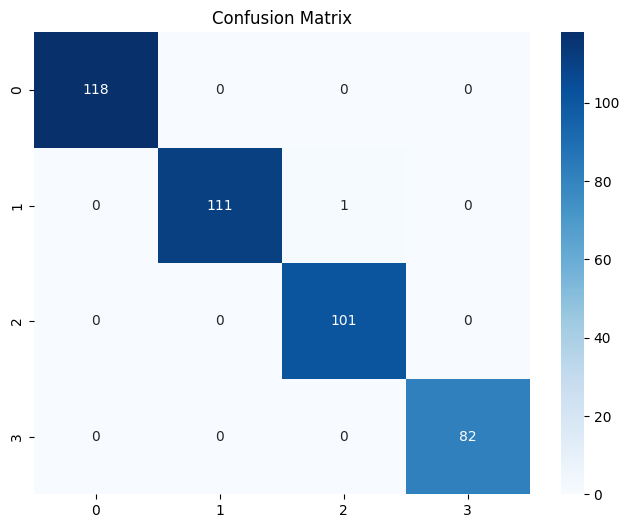

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 81s 6s/step


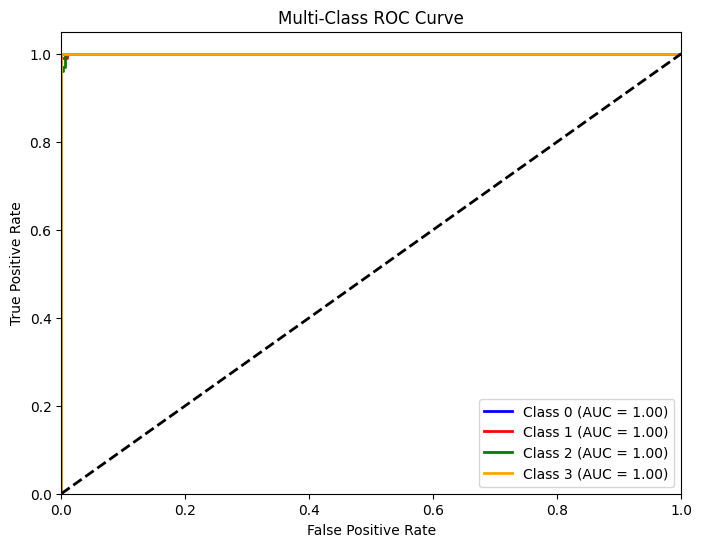

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# 1. Binarize the true labels (for multi-class ROC)
y_true = test_set.classes
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
n_classes = y_true_bin.shape[1]

# 2. Get predicted probabilities
y_pred_prob = model.predict(test_set)

# 3. Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4. Plot ROC curves
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green', 'orange'])  # Adjust colors to match # of classes

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()

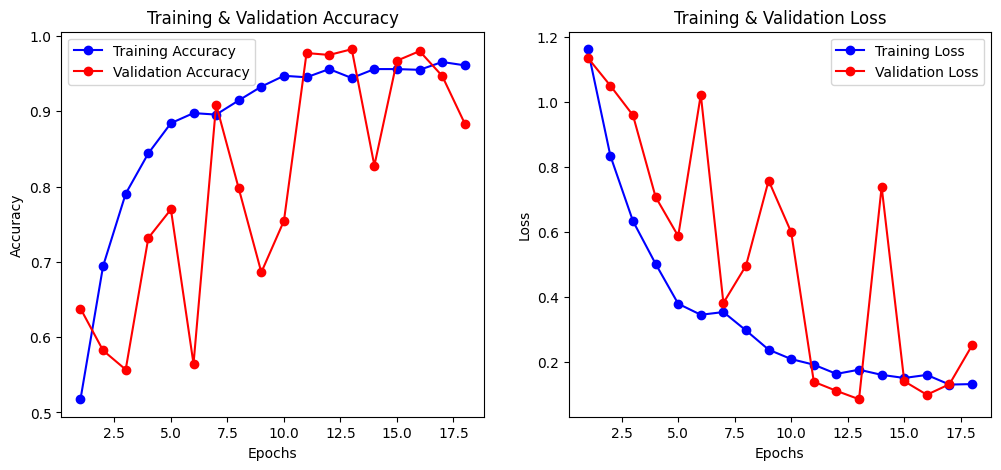

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_history(history):
    # Extract training history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)  # Get number of epochs

    # Plot Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    plt.show()

# Call the function with model history
plot_history(history)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')  # Weighted for imbalanced classes
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9976
Precision: 0.9976
Recall: 0.9976
F1 Score: 0.9976


13/13 ━━━━━━━━━━━━━━━━━━━━ 74s 6s/step


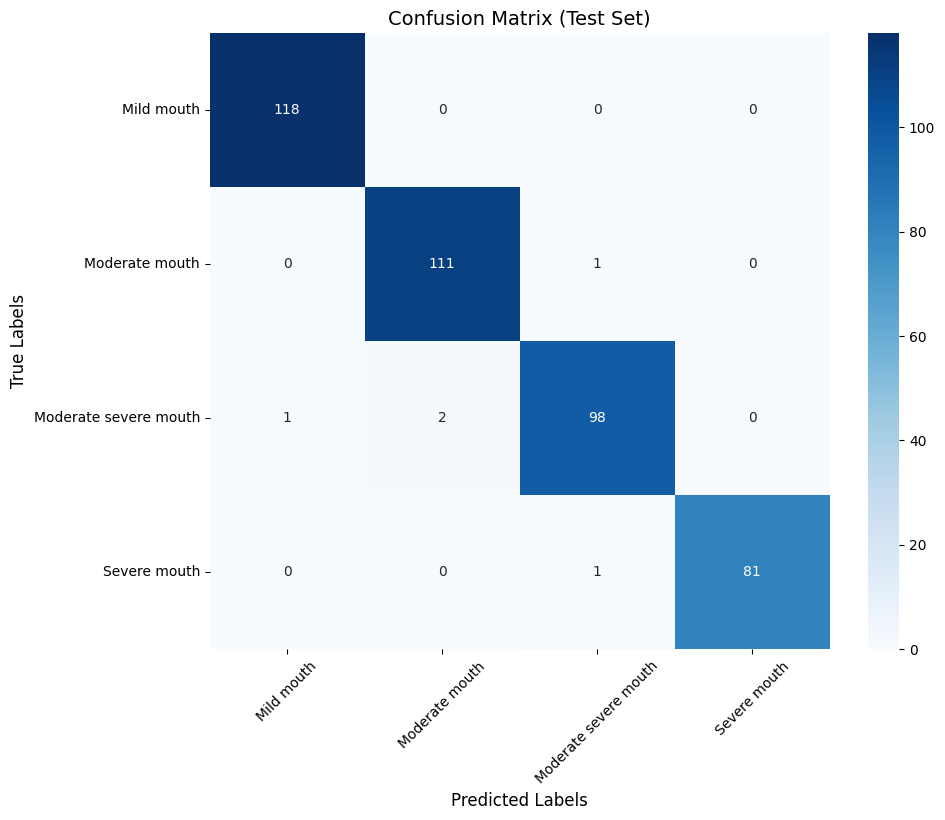


Classification Report:
                       precision    recall  f1-score   support

           Mild mouth       0.99      1.00      1.00       118
       Moderate mouth       0.98      0.99      0.99       112
Moderate severe mouth       0.98      0.97      0.98       101
         Severe mouth       1.00      0.99      0.99        82

             accuracy                           0.99       413
            macro avg       0.99      0.99      0.99       413
         weighted avg       0.99      0.99      0.99       413



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Get true labels and predictions
y_true = test_set.classes
y_pred = model.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)

# 2. Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# 3. Plot with annotations and improved visuals
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_set.class_indices.keys(),
            yticklabels=test_set.class_indices.keys())
plt.title('Confusion Matrix (Test Set)', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# 4. Print classification metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes,
                          target_names=test_set.class_indices.keys()))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


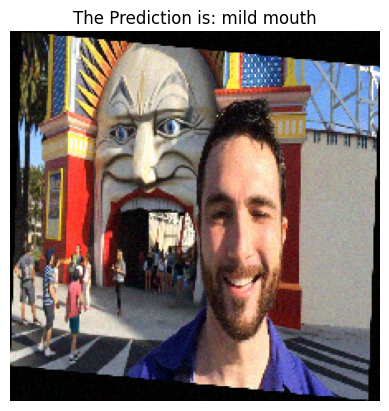

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


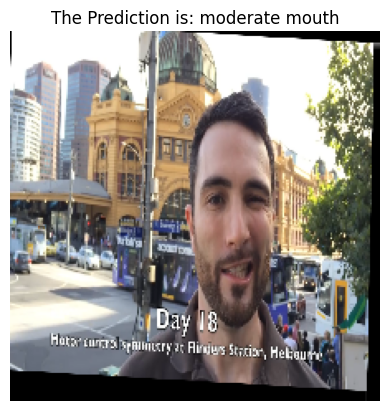

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
best_model=load_model(f"bellspalsy_model_lr_{lr}.h5")

def predict_and_display(image_path, model, class_labels):

    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)

    predicted_class_label = class_labels[predicted_class_index]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"The Prediction is: {predicted_class_label}")
    plt.show()

# Load your trained model
best_model.load_weights(f"bellspalsy_model_lr_{lr}.h5")

# Define your class labels (e.g., ['car', 'truck', ...])
class_labels = [ 'mild mouth', 'moderate mouth', 'moderate severe mouth', 'severe mouth']

# Replace 'path_to_test_image' with the path to the image you want to test
image_1 = r"/content/drive/My Drive/Mouth/test/Mild mouth/noisy_25dB_14_Mi_mouth13.bmp"
image_2 = r"/content/drive/My Drive/Mouth/test/Moderate mouth/translated20_14_M_mouth4.bmp"

predict_and_display(image_1, model, class_labels)
predict_and_display(image_2, model, class_labels)